# Craiglist car data to time series

Adding the necessay imports

In [1]:
import re
import warnings

import warnings
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import statsmodels.api as sm
import matplotlib

In [2]:
warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")
rcParams["figure.figsize"] = 18, 8

## Reading the input file
This assumes that the input file has been downloaded from https://drive.google.com/file/d/1qBoDJiEBt-7QmSmmUbacBU33RByTZkJg/view?usp=drive_link and extacted to `/data` directory where the notebook runs.

In [3]:
df = pd.read_csv("data/craigslist_vehicles.csv")

## Data exploration

We need to do some exploration to have a better understanding of the data

### Getting the columns in the dataset

In [4]:
df.columns

Index(['Unnamed: 0', 'id', 'url', 'region', 'region_url', 'price', 'year',
       'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer',
       'title_status', 'transmission', 'VIN', 'drive', 'size', 'type',
       'paint_color', 'image_url', 'description', 'county', 'state', 'lat',
       'long', 'posting_date', 'removal_date'],
      dtype='object')

The are 27 columns in the dataset. The `id` column is a unique id to each entry in the dataset. The `posting_date` is the date the entry was added to the dataset. The `removal_date` is the date the entry was removed. The rest of the columns are various properties of the added vehicles. For example, `year` should be the year of manufacture and `model` is the model of the car.

### Unique counts for each column

In [5]:
df.nunique()

Unnamed: 0      426880
id              426880
url             426880
region             404
region_url         413
price            15655
year               114
manufacturer        42
model            29667
condition            6
cylinders            8
fuel                 5
odometer        104870
title_status         6
transmission         3
VIN             118264
drive                3
size                 4
type                13
paint_color         12
image_url       241899
description     360911
county               0
state               51
lat              53181
long             53772
posting_date        32
removal_date        88
dtype: int64

### Null values

In [6]:
df.isna().sum()

Unnamed: 0           0
id                   0
url                  0
region               0
region_url           0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
image_url           68
description         70
county          426880
state                0
lat               6549
long              6549
posting_date        68
removal_date        68
dtype: int64

Using the information on the null value count and the unique value counts, I have decided to generate the time series using the following columns:
- model
- region
- drive
- state
- transmission
I have only selected these columns for testing for now, but we can generate time series for whichever columns we want.

The independent time variables will the `posting_date` and the `removal_date` columns.

## Data preprocessing

I am only going to give some examples of data preproessing that can be done to ensure that our data is ready to generate the time series. These included the following:
- For the `model` column, we can do the following
    - Cleanup some column values: For example, some model values are misspelt. We can find a way of correcting the spelling issues.
    - We can fill the missing model values with values obtained from https://www.bumper.com/
- For the `drive` column, we can do the following:
    - Fill the missing values with value obtained from https://www.bumper.com/ for rows with non-empty `VIN`
    - We can also use the modal value of drive type for vehicles of the same model
- For the numeric columns, we can fill the missing values as follows:
    - For continuos values like `odometer` we can fill the missing values with the average values of similar vehicles.
    - For non-continuos values like `year`, we can use the mode of similar vehicles.

I am not going to implement this step for now due to limited time.

## Data Validation

It is important to ensure we are using the correct data to generate the time series. The following are some of the validation steps that can be attempted:
- We can use https://www.bumper.com/ to validate the information about a vehicle for a given `VIN` is correct
- We can attempt to correct some values that are obviously wrong, for example a vehicle with `cylinders` value of a very big number like that does not make sense. In this can we can use the mean or mode of similar vehicles.
- We can validate for the correct column types to ensure we only have valida values.

I am also not implementing this step due to time.

## Utility Functions

With the above steps complete, we can go ahead and generate the time series for the columns we want. I have written a number of utility functions to aid doing that.

### Function to generate time series

This function takes a pandas dataframe, the column of the dataframe and a value of the column to generate a time series. For example, the function can take the column `model` and value `f-150` to generate 2 time series for both posting and removal.

In [7]:
# function to get the time series
def get_time_series(df, data_column, value):
    # Create the plot
    df_to_plot = df[df[data_column] == value]
    posted_df = (
        df_to_plot.groupby("posting_date").agg({data_column: "count"}).reset_index()
    )
    posted_number_col = f"{data_column}_{value}_posted"
    posted_df.rename(
        columns={"posting_date": "date", data_column: posted_number_col}, inplace=True
    )
    removed_df = (
        df_to_plot.groupby("removal_date").agg({data_column: "count"}).reset_index()
    )
    removed_number_col = f"{data_column}_{value}_removed"
    removed_df.rename(
        columns={"removal_date": "date", data_column: removed_number_col}, inplace=True
    )
    merged_df = pd.merge(posted_df, removed_df, on=["date"], how="outer")
    merged_df.fillna(0, inplace=True)
    return merged_df

### Function to get the available number each day

The available number is the number vehicles posted minus the number of vehicles removed. This helps in the management of the inventory. This function takes the output of the function above and adds a column for the available number.

In [8]:
# function to add available columns
def add_available_columns(time_series_df):
    data_columns = time_series_df.columns.to_list()
    common_cols = list(set([re.sub(r"_[a-z]+$", "", col) for col in data_columns]))
    for col in common_cols:
        available_col = f"{col}_available"
        time_series_df[available_col] = (
            time_series_df[f"{col}_posted"] - time_series_df[f"{col}_removed"]
        ).cumsum()
    columns = time_series_df.columns.to_list()
    return time_series_df[sorted(columns)]

### Generating the time series

As already mentioned above, I will be generating a number of time series using the 5 selected columns above. I will also not be generating the series for all the values of the columns, I will only use the 2 most occuring values per column. We can use all the values if we want, but I have chosen to only use a few for illustration purposes.

In [14]:
columns_to_use = ["model", "region", "drive", "state", "transmission"]
time_series_df = pd.DataFrame()
for column in columns_to_use:
    # using only the most frequent values for each column
    frequent_col_values = df[column].value_counts()[:2].keys()
    for col_value in frequent_col_values:
        if time_series_df.empty:
            time_series_df = get_time_series(df, column, col_value)
            continue
        time_series_df = pd.merge(
            time_series_df, get_time_series(df, column, col_value), on=["date"], how="outer"
        )
time_index = pd.DatetimeIndex(time_series_df["date"])
time_series_df.set_index(time_index, inplace=True)
time_series_df = time_series_df.resample("D").sum()
time_series_df = add_available_columns(time_series_df)
time_series_df.reset_index(inplace=True)

### Results

The output has a total of 30 time series i.e `5 columns * 2 most frequent values per column * 3(for posting, removal and available[posting - removal])` with `date` as the index.
I filled missing values with appropriate values to ensure continuity of the data series for plotting purposes. For `posted` and `removed`, it is okay to fill nulls with `0`. For available, I did a forward fill.

In [11]:
time_series_df.columns

['date',
 'drive_4wd_available',
 'drive_4wd_posted',
 'drive_4wd_removed',
 'drive_fwd_available',
 'drive_fwd_posted',
 'drive_fwd_removed',
 'model_f-150_available',
 'model_f-150_posted',
 'model_f-150_removed',
 'model_silverado 1500_available',
 'model_silverado 1500_posted',
 'model_silverado 1500_removed',
 'region_columbus_available',
 'region_columbus_posted',
 'region_columbus_removed',
 'region_jacksonville_available',
 'region_jacksonville_posted',
 'region_jacksonville_removed',
 'state_ca_available',
 'state_ca_posted',
 'state_ca_removed',
 'state_fl_available',
 'state_fl_posted',
 'state_fl_removed',
 'transmission_automatic_available',
 'transmission_automatic_posted',
 'transmission_automatic_removed',
 'transmission_other_available',
 'transmission_other_posted',
 'transmission_other_removed']

In [15]:
matplotlib.rcParams["axes.labelsize"] = 14
matplotlib.rcParams["xtick.labelsize"] = 12
matplotlib.rcParams["ytick.labelsize"] = 12
matplotlib.rcParams["text.color"] = "k"

#### Plotting some of the time series

I have plotted some the time series above as shown below. The first line chart for the plots are the for the actual values while the remaining ones are for the `trend`, `seasonal` and `residual` constituents using an additive model.

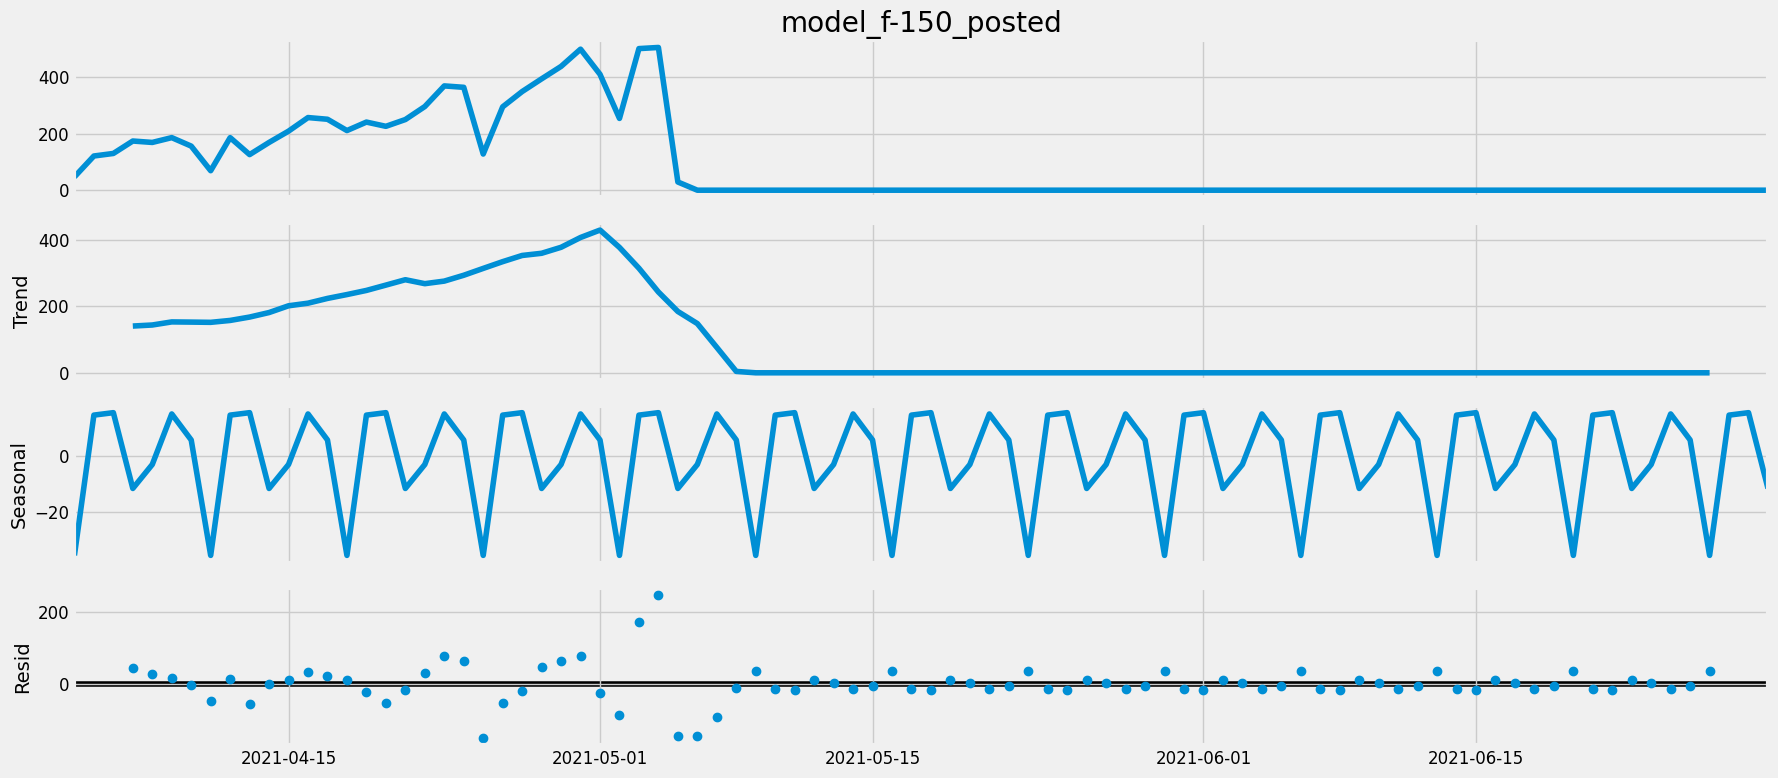

In [16]:
time_index = pd.DatetimeIndex(time_series_df["date"])
time_series_df.set_index(time_index, inplace=True)

decomposition = sm.tsa.seasonal_decompose(time_series_df["model_f-150_posted"], model="additive")
fig = decomposition.plot()
plt.show()

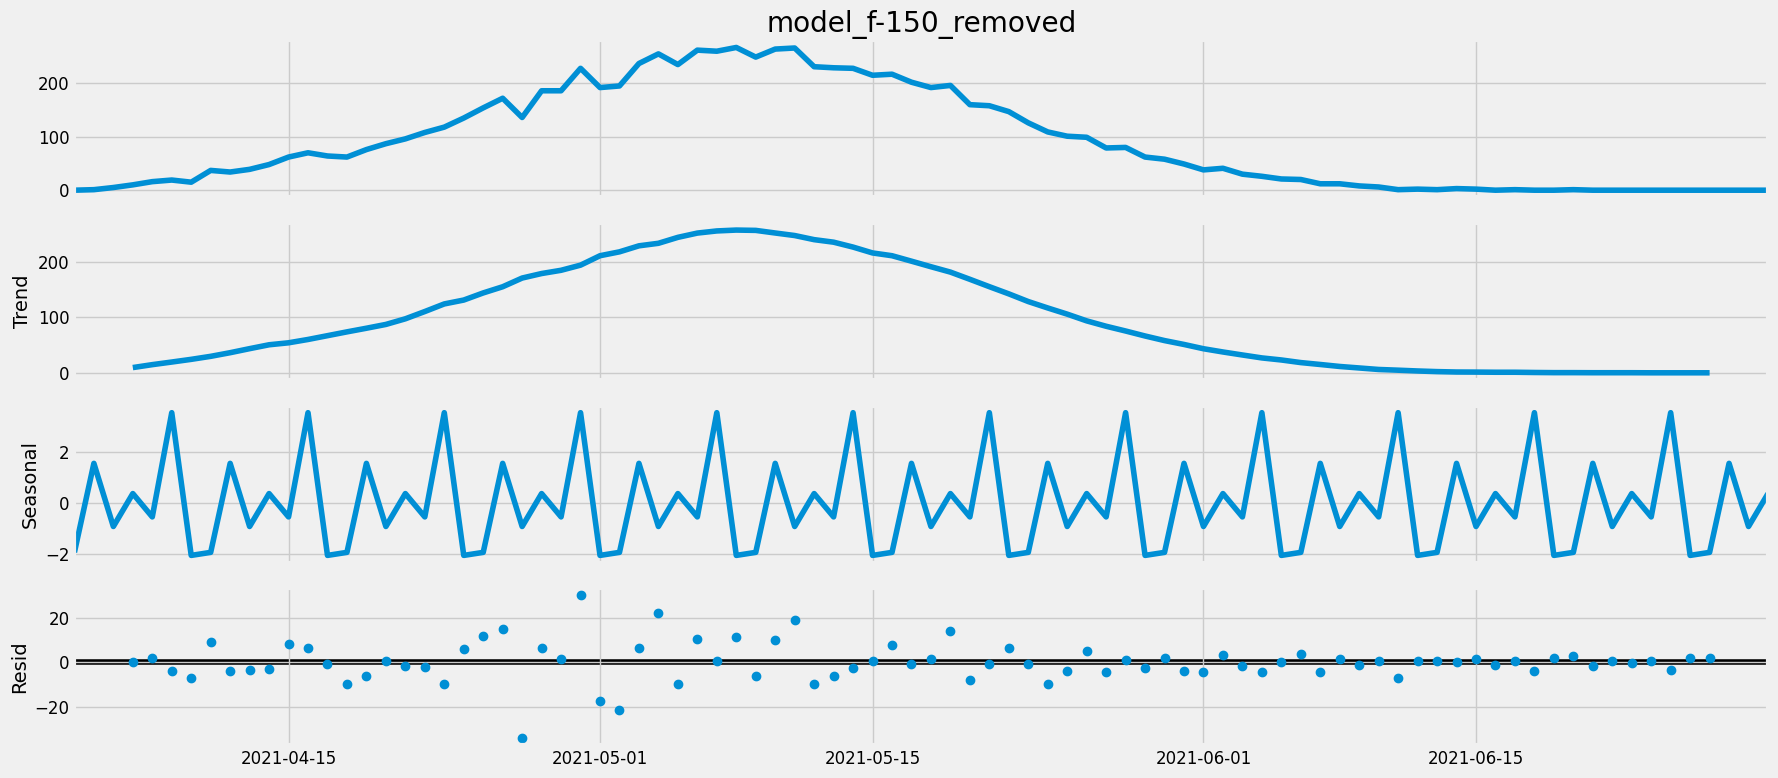

In [17]:
time_index = pd.DatetimeIndex(time_series_df["date"])
time_series_df.set_index(time_index, inplace=True)

decomposition = sm.tsa.seasonal_decompose(time_series_df["model_f-150_removed"], model="additive")
fig = decomposition.plot()
plt.show()

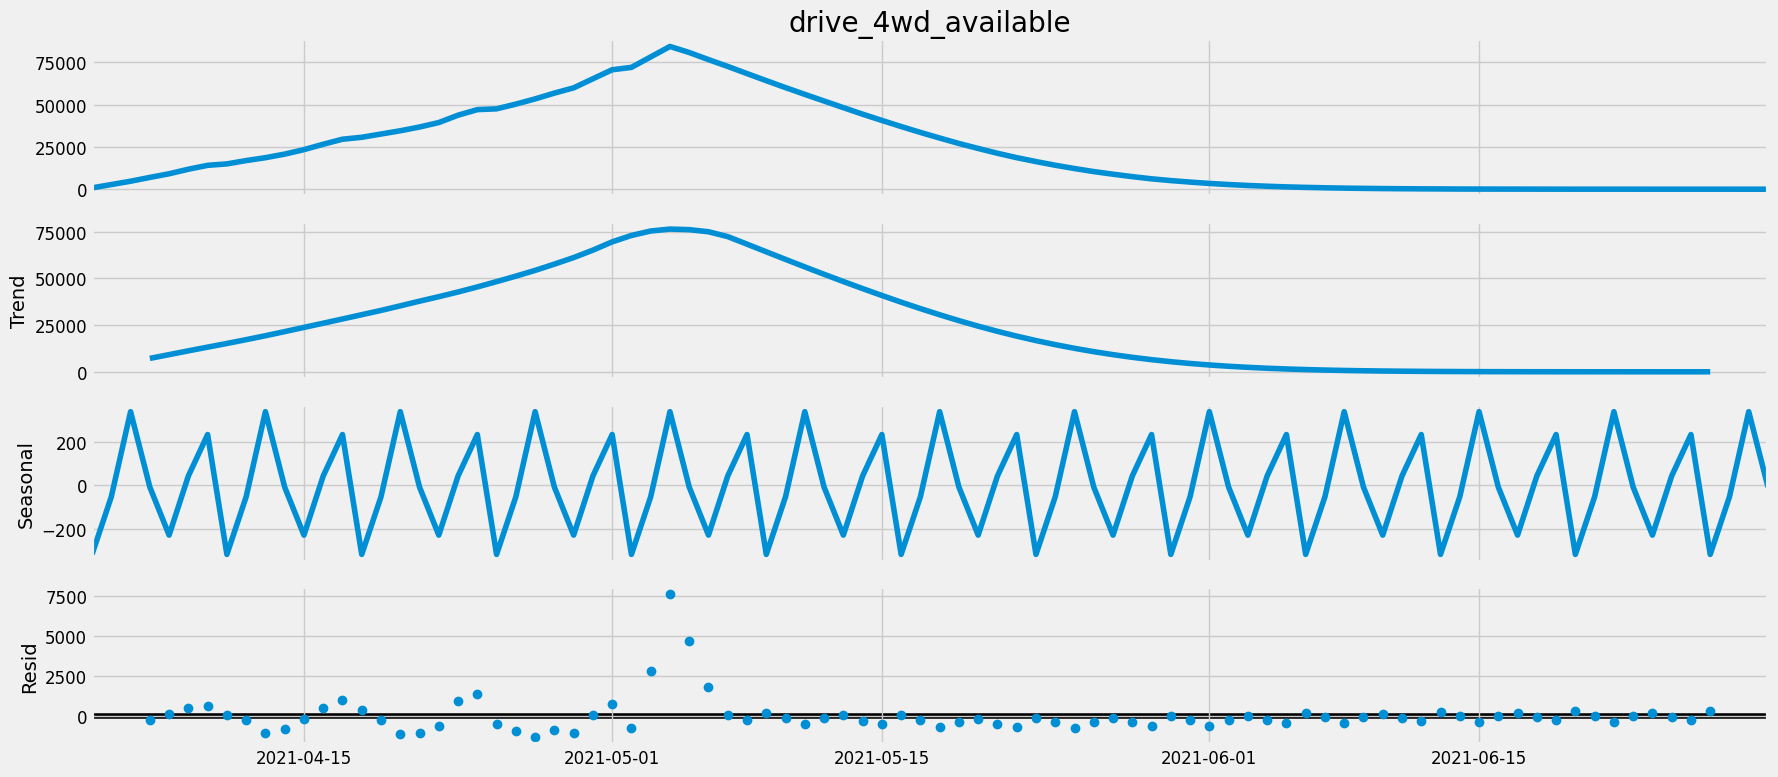

In [18]:
# plotting the data
decomposition = sm.tsa.seasonal_decompose(time_series_df["drive_4wd_available"], model="additive")
fig = decomposition.plot()
plt.show()

## Conclusion

The above has just been an illustration of how we can derive a number of time series from the initial data. I had all the data series in a single dataframe, but it is actually ideal to have each data series in its own dataframe. For example, for `model_f-150_posted`, we can have a single dataframe with aditional common columns for the `f-150` model. These columns include the `model_name`, `manufacture`, `engine_capacity` e.tc. This dataframe can map directly to the DB where we store the specific series.